# Aplicar DecisionTreeRegressor y DecisionTreeClassifier sobre los datos limpios.

**Autor:** Jean Pool Marín Betancur  
**Fecha:** 2025-06-05
**Versión:** 1.0 

# Introducción
Este notebook se centra en modelar el consumo de energía renovable en Estados Unidos utilizando técnicas de aprendizaje automático, específicamente modelos de Árboles de Decisión. El conjunto de datos, `US_Renewable_Energy_Consumption_Imputed.csv`, contiene datos mensuales sobre varias fuentes de energía renovable desde 1973 hasta 2023. Los objetivos principales son:
1. **Regresión**: Predecir el consumo de `Energía Solar` utilizando un modelo `DecisionTreeRegressor` basado en características temporales (año y mes).
2. **Clasificación**: Clasificar el consumo de `Energía Eólica` en niveles discretos (por ejemplo, Bajo, Medio, Alto) usando un modelo `DecisionTreeClassifier`.
3. Optimizar los hiperparámetros de los modelos y evaluar su rendimiento con métricas adecuadas.

El notebook está estructurado para cargar y preprocesar los datos, entrenar y evaluar los modelos, y guardar los resultados para uso futuro. Se incluyen visualizaciones para facilitar la interpretación de los resultados.

---
# 1. Configuración del Entorno e Importaciones:

En esta sección, se configuran las herramientas necesarias para el análisis y modelado. Se importan las siguientes librerías:
- **Pandas y NumPy**: Para la manipulación y análisis de datos.
- **Matplotlib y Seaborn**: Para la visualización de datos y resultados.
- **Scikit-learn**: Para implementar los modelos de Árboles de Decisión (`DecisionTreeRegressor` y `DecisionTreeClassifier`), optimización de hiperparámetros (`GridSearchCV`), y evaluación de métricas (`mean_squared_error`, `accuracy_score`, etc.).
- **Joblib**: Para guardar los modelos entrenados.

Además, se configuran parámetros de visualización y formato para mejorar la legibilidad de los resultados.

---

In [24]:
# Se importan las librerias necesarias.
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
import joblib

In [25]:
# Configuración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

In [26]:
# Se define la ruta y se cargan los datos limpios.
data_path = os.path.join('..','..', '01_data_preparation', 'data', 'processed', 'US_Renewable_Energy_Consumption_Imputed.csv')
df_processed = pd.read_csv(data_path , index_col='Datetime', parse_dates=True)
# Se definen las columnas de interés.
comsumption_columns = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant','Biomass Losses and Co-products',
    'Biomass Energy','Renewable Diesel Fuel','Total Renewable Energy',
    'Other Biofuels','Conventional Hydroelectric Power', 'Biodiesel'
]
#  Se agrupan los sectores de consumo de energía renovable.
df_processed = df_processed.groupby(['Datetime'])
df_processed = df_processed[comsumption_columns].sum()
df_processed 

,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Renewable Diesel Fuel,Total Renewable Energy,Other Biofuels,Conventional Hydroelectric Power,Biodiesel
Datetime,,,,,,,,,,,,,,
1973-01-01,3.07,1.91,0.00,0.00,144.93,0.61,0.00,0.00,199.16,0.00,691.84,0.00,342.16,0.00
1973-02-01,4.92,2.27,0.00,0.00,131.06,0.76,0.00,0.00,180.10,0.00,724.38,0.00,405.26,0.00
1973-03-01,5.23,2.41,0.00,0.00,145.08,0.87,0.00,0.00,199.35,0.00,781.21,0.00,428.27,0.00
1973-04-01,5.13,2.65,0.00,0.00,140.30,0.91,0.00,0.00,192.84,0.00,756.48,0.00,414.65,0.00
1973-05-01,5.21,2.62,0.00,0.00,144.94,1.00,0.00,0.00,199.25,0.00,771.23,0.00,418.22,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1.25,12.46,108.46,97.45,185.60,50.66,158.63,343.87,565.75,169.77,"2,153.36",13.12,339.75,106.58
2023-09-01,1.16,12.29,94.78,96.38,174.87,49.30,143.97,337.83,535.64,176.77,"2,041.20",16.29,289.30,112.62
2023-10-01,1.06,12.71,86.24,124.56,176.67,52.65,157.14,349.48,552.91,165.63,"2,115.98",18.47,305.87,112.59


## 2. Regresión con *DesicionTreeRegressor*

### 2.1 Definición del problema de regresión.

Para comenzar se debe tener claro el problema en cuestión que se desea solucionar por medio del algoritmo de *Arbol de Desición*, para esto se debe definir principalmente la variable objetivo o *target* del problema y sus variables independientes o *features*, para el correcto entrenmiento del modelo. 

Para este caso analizando la dataset de *Consumo de Energías Renovables en EEUU (1973 -2024)*,  se identificó una fuente de energía en cuestión como posible candidata debido a su crecimiento emergente e importancia en la última decada, esta fuente de energía corresponde a `Solar Energy`, por lo que se definirá como la variable objetivo o *target* del problema, mientras que las variables independientes o *features* corresponderán a cada uno de los años y meses del dataset, de tal forma que se pueda entrenar un modelo que prediga el consumo de energía solar en función de los años y meses.

In [27]:
# Definir Variable Objetivo y Características Iniciales
target_reg = 'Solar Energy' # Variable objetivo para regresión

# --- Crear Características (Features) ---
df_features_reg = df_processed.copy()

# Características Temporales Básicas (del índice datetime)
df_features_reg['year'] = df_features_reg.index.year
df_features_reg['month'] = df_features_reg.index.month

# Columnas a excluir
features_to_exclude = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant','Biomass Losses and Co-products',
    'Biomass Energy','Renewable Diesel Fuel','Total Renewable Energy',
    'Other Biofuels','Conventional Hydroelectric Power', 'Biodiesel', 'Sector'
]


In [28]:
# Se definen las caracteristicas potenciales para el modelo de regresión.
final_features_reg = [col for col in df_features_reg.columns if col not in features_to_exclude]

# Se definen las variables de entrenamiento y prueba.
X_reg = df_features_reg[final_features_reg]
y_reg = df_features_reg[target_reg]

print(f"\nForma de X_reg (características): {X_reg.shape}")
print(f"Forma de y_reg (objetivo): {y_reg.shape}")
print("\nPrimeras filas de X_reg:")
print(X_reg.head())
print("\nPrimeras filas de y_reg:")
print(y_reg.head())
print("\nCaracterísticas finales para regresión:")
print(final_features_reg)


Forma de X_reg (características): (612, 2)
Forma de y_reg (objetivo): (612,)

Primeras filas de X_reg:
            year  month
Datetime               
1973-01-01  1973      1
1973-02-01  1973      2
1973-03-01  1973      3
1973-04-01  1973      4
1973-05-01  1973      5

Primeras filas de y_reg:
Datetime
1973-01-01   0.00
1973-02-01   0.00
1973-03-01   0.00
1973-04-01   0.00
1973-05-01   0.00
Name: Solar Energy, dtype: float64

Características finales para regresión:
['year', 'month']


### 2.2 División de Datos (Cronológica)

Una vez identifica el modelo y su forma, se procede a dividir los datos potenciales en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba. El conjunto de entrarnamiento se utiliza para entrenar el modelo, mientras que el conjunto de prueba se utiliza para evaluar su rendimiento. La proporción de datos entre el conjunto de entrenamiento y el conjunto de prueba es importante, ya que un conjunto de entrenamiento demasiado grande puede llevar a un modelo que se adapte demasiado a los datos de entrenamiento y no genere buenos resultados en el conjunto de prueba, para este caso se escoje el 80% para el conjunto de entrenamiento y el 20% para el conjunto de prueba.

In [29]:
# División de datos cronológica
train_ratio = 0.8 # Usar el 80% de los datos para entrenar, el 20% para probar

# El split debe ser en el mismo punto para X e y
split_point_reg = int(len(X_reg) * train_ratio)

X_train_reg, X_test_reg = X_reg.iloc[:split_point_reg], X_reg.iloc[split_point_reg:]
y_train_reg, y_test_reg = y_reg.iloc[:split_point_reg], y_reg.iloc[split_point_reg:]

print("División de datos para Regresión:")
print(f"Forma de X_train_reg: {X_train_reg.shape}, Forma de y_train_reg: {y_train_reg.shape}")
print(f"Forma de X_test_reg: {X_test_reg.shape}, Forma de y_test_reg: {y_test_reg.shape}")
print(f"Fechas de entrenamiento: {X_train_reg.index.min()} a {X_train_reg.index.max()}")
print(f"Fechas de prueba: {X_test_reg.index.min()} a {X_test_reg.index.max()}")

División de datos para Regresión:
Forma de X_train_reg: (489, 2), Forma de y_train_reg: (489,)
Forma de X_test_reg: (123, 2), Forma de y_test_reg: (123,)
Fechas de entrenamiento: 1973-01-01 00:00:00 a 2013-09-01 00:00:00
Fechas de prueba: 2013-10-01 00:00:00 a 2023-12-01 00:00:00


### 2.3  Entrenamiento del DecisionTreeRegressor

Teniendo en cuenta la división realida para los datos, se realiza el entrenamiento del modelo considerando ciertos hiperparámetros base para observar su funcionamiento inicial y que tan bien se adapta a los datos. Además tambien se gráfica el arbol de decisión para visualizar la estructura del modelo y observar por intervalos como se distribuyen los datos para la predicción y cuanto error se puede esperar.

In [30]:
# Entrenamiento del Modelo
dtr = DecisionTreeRegressor(
    random_state=42, # Para reproducibilidad
    max_depth=5,      # Controla la complejidad del árbol, previene overfitting
    min_samples_split=5, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=3   # Mínimo de muestras en una hoja
)

# Ajustar el modelo
dtr.fit(X_train_reg, y_train_reg)

print("Modelo DecisionTreeRegressor entrenado.")
print("Parámetros del modelo:", dtr.get_params())


Modelo DecisionTreeRegressor entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


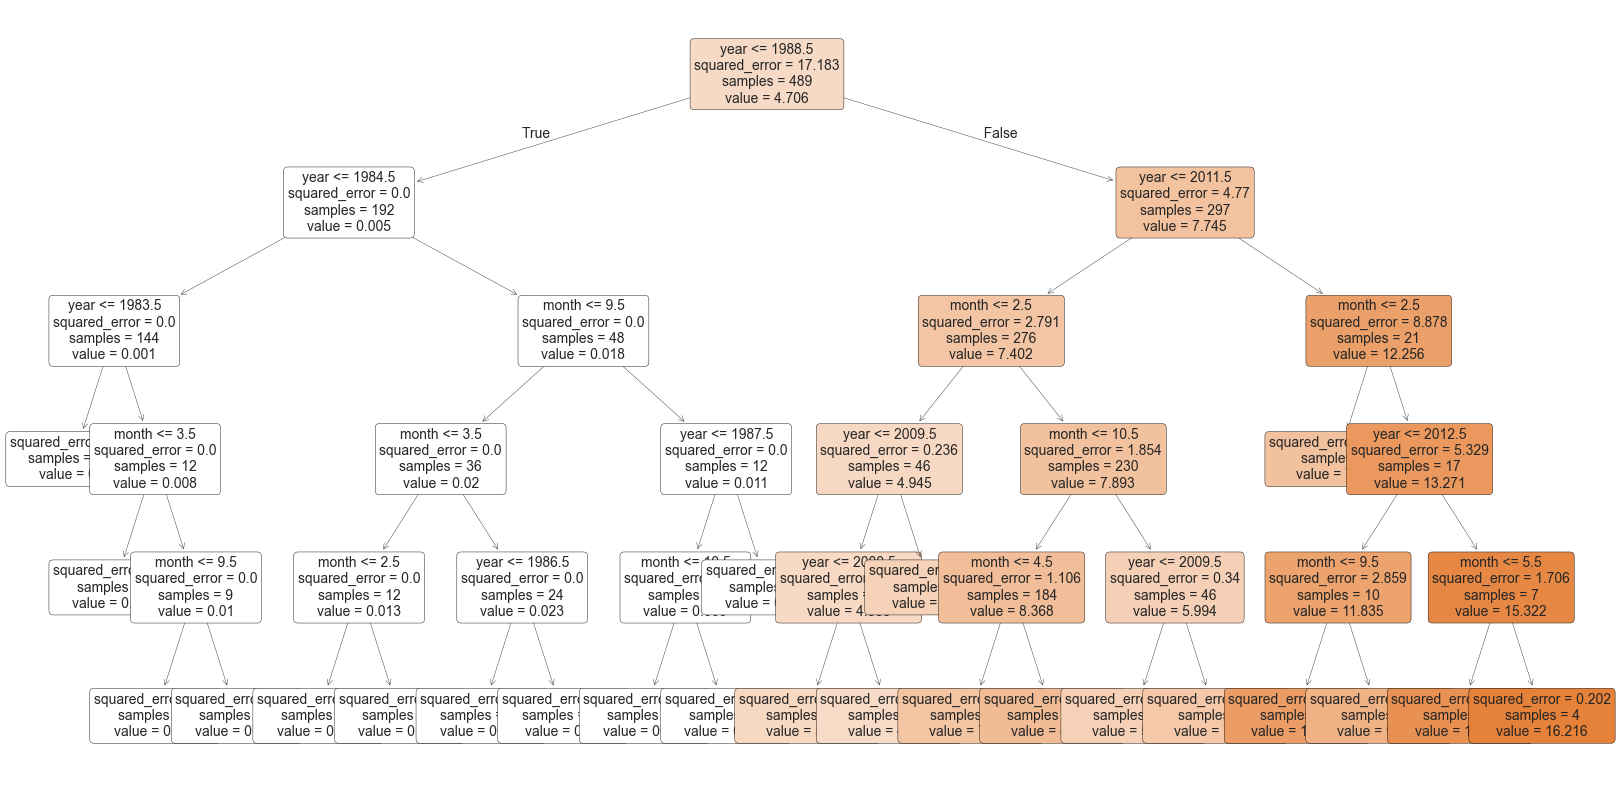

In [31]:
# Se gráfica el arbol de decisión del modelo entrenado.
plt.figure(figsize=(20, 10))

# Plotear el árbol de decisión
plot_tree(
    dtr, 
    feature_names=X_train_reg.columns,  # Nombres de las características
    filled=True,                        # Colorea los nodos según la pureza
    rounded=True,                       # Bordes redondeados en los nodos
    fontsize=10                         # Tamaño de la fuente
)

# Mostrar el gráfico
plt.show()

### 2.4 Predicciones y Evaluación (Regresión)

Luego de tener el módelo entrenado, se utilizan los datos de testo para predecir los valores de la variable objetivo, esto nos dará como resultado la variable de salida predecida, la cual por medio de funciones propias de *Scikitlearn* se puede comparar con la variable objetivo real para obtener las métricas de precisión del modelo y evaluar su desempeño.


--- Resultados de Evaluación para DecisionTreeRegressor (Solar Energy) ---
RMSE (Error Cuadrático Medio Raíz): 1510.2460
MAE (Error Absoluto Medio): 30.3379
R² (Coeficiente de Determinación): -1.4071


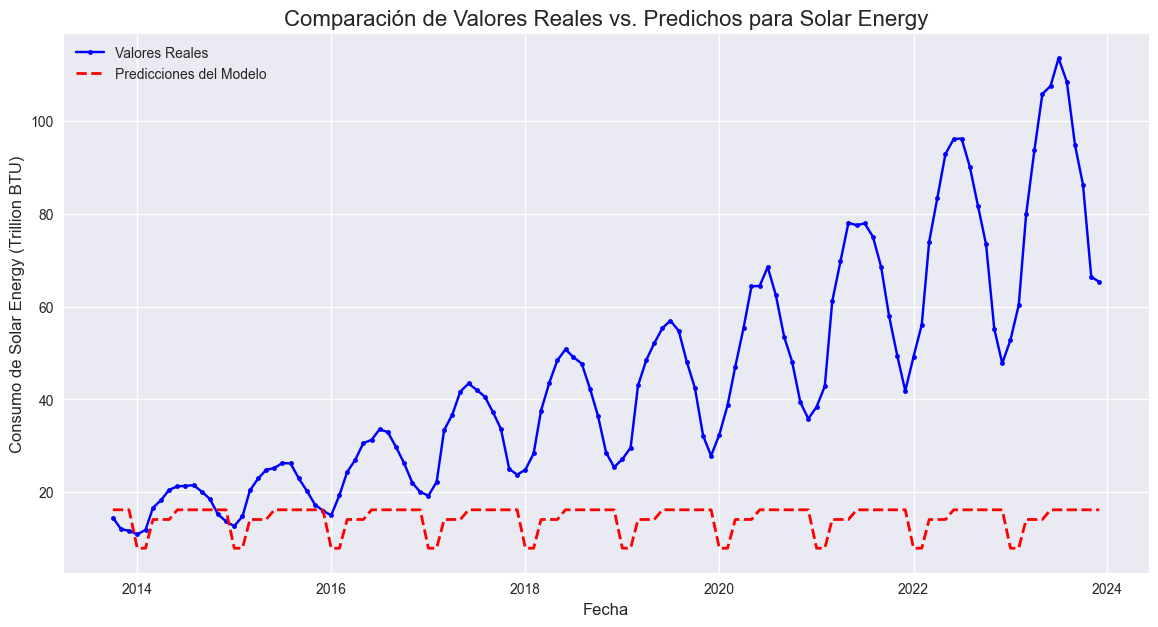

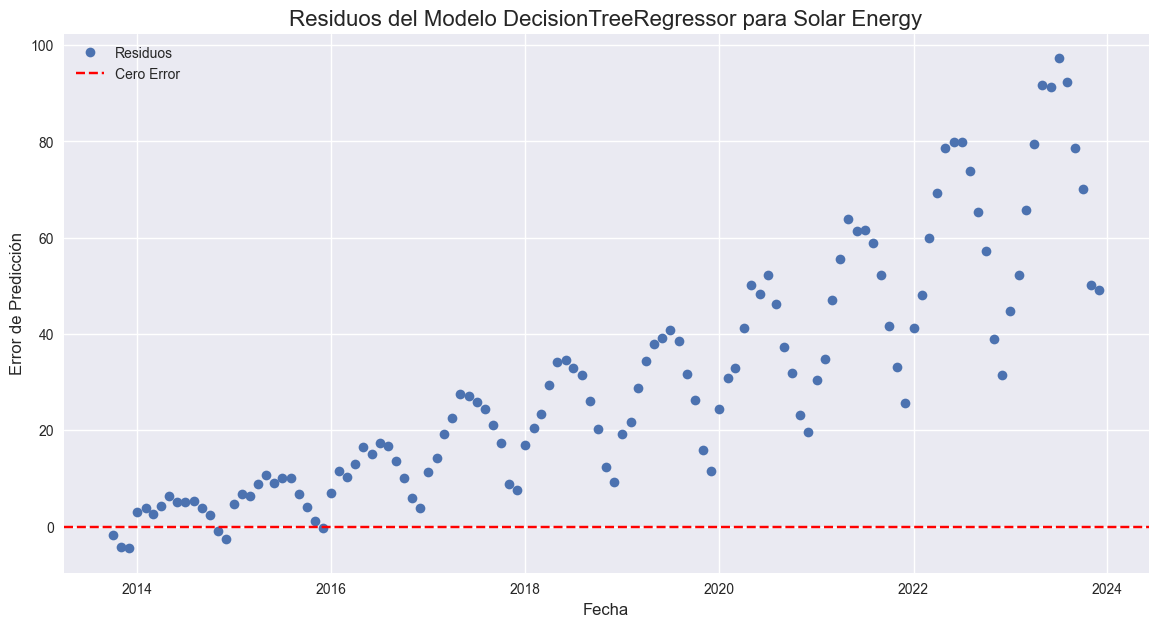

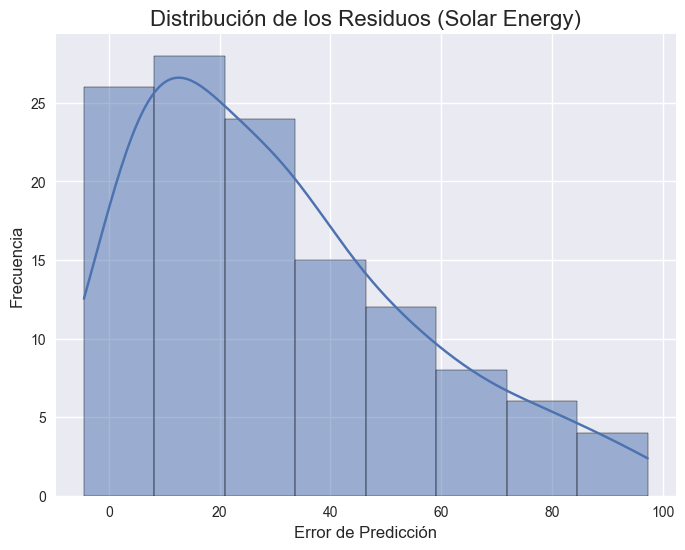

In [32]:
# Realizar predicciones en el conjunto de prueba
y_pred_reg = dtr.predict(X_test_reg)

# Calcular métricas de evaluación
rmse_reg = mean_squared_error(y_test_reg, y_pred_reg)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"\n--- Resultados de Evaluación para DecisionTreeRegressor ({target_reg}) ---")
print(f"RMSE (Error Cuadrático Medio Raíz): {rmse_reg:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_reg:.4f}")
print(f"R² (Coeficiente de Determinación): {r2_reg:.4f}")

# --- Visualización de Predicciones vs. Reales ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_reg.index, y_test_reg, label='Valores Reales', marker='.', linestyle='-', color='blue')
plt.plot(y_test_reg.index, y_pred_reg, label='Predicciones del Modelo', marker='x', linestyle='--', color='red', linewidth=2)
plt.title(f'Comparación de Valores Reales vs. Predichos para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo de {target_reg} (Trillion BTU)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Residuos ---
# Los residuos son la diferencia entre los valores reales y los predichos
residuos_reg = y_test_reg - y_pred_reg
plt.figure(figsize=(14, 7))
plt.plot(residuos_reg.index, residuos_reg, label='Residuos', marker='o', linestyle='None')
plt.axhline(0, color='red', linestyle='--', label='Cero Error')
plt.title(f'Residuos del Modelo DecisionTreeRegressor para {target_reg}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Error de Predicción', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(residuos_reg, kde=True)
plt.title(f'Distribución de los Residuos ({target_reg})', fontsize=16)
plt.xlabel('Error de Predicción', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.show()

El análisis del modelo DecisionTreeRegressor revela un rendimiento limitado en la predicción del consumo de energía solar. Si bien el modelo captura tendencias iniciales entre 2014 y 2020, subestima significativamente los picos de consumo a partir de 2020, con errores de hasta 60 trillones de BTU. Esto se refleja en un R² de -1.471, un RMSE de 1510.24 y un MAE de 30.3379, indicando que, aunque muchos errores son pequeños, los errores en los valores altos afectan gravemente el ajuste. Se recomienda explorar modelos más robustos, como Random Forest o Gradient Boosting, para mejorar la precisión en la predicción de picos de consumo.

### 2.5 Optimización de Hiperparámetros

Debido a que el modelo no posee el rendimiento adecuado, se optimizan los hiperparámetros del DecisionTreeRegressor (como max_depth y min_samples_split) usando GridSearchCV con TimeSeriesSplit. La métrica R² evalúa el rendimiento en el conjunto de prueba. 

In [33]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de regresión.
param_grid_dtr = {
    'max_depth': [3, 5, 7, 10, None], # None significa sin límite
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['squared_error', 'absolute_error'] # Antes 'mse', 'mae'
}
# TimeSeriesSplit divide los datos en k folds consecutivos
tscv = TimeSeriesSplit(n_splits=5) # Usar menos splits si el dataset de entreno es pequeño

grid_search_dtr = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dtr,
    cv=tscv,
    scoring='neg_mean_squared_error', # GridSearchCV maximiza, por eso negativo
    verbose=1, # Muestra progreso
    n_jobs=-1 # Usa todos los procesadores
) 

grid_search_dtr.fit(X_train_reg, y_train_reg)

print(f"\nMejores Hiperparámetros para DecisionTreeRegressor: {grid_search_dtr.best_params_}")
print(f"Mejor puntuación (neg_MSE) en CV: {grid_search_dtr.best_score_:.4f}")


Fitting 5 folds for each of 90 candidates, totalling 450 fits

Mejores Hiperparámetros para DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor puntuación (neg_MSE) en CV: -8.9406


In [34]:
# Entrenar el modelo final con los mejores parámetros
best_dtr = grid_search_dtr.best_estimator_

# Re-evaluar el mejor modelo en el conjunto de prueba
y_pred_best_dtr = best_dtr.predict(X_test_reg)
rmse_best_dtr = mean_squared_error(y_test_reg, y_pred_best_dtr)
mae_best_dtr = mean_absolute_error(y_test_reg, y_pred_best_dtr)
r2_best_dtr = r2_score(y_test_reg, y_pred_best_dtr)

print(f"\n--- Resultados del Mejor DTR en Test Set ---")
print(f"RMSE: {rmse_best_dtr:.4f}")
print(f"MAE: {mae_best_dtr:.4f}")
print(f"R²: {r2_best_dtr:.4f}")


--- Resultados del Mejor DTR en Test Set ---
RMSE: 1503.2927
MAE: 30.2220
R²: -1.3961


### 2.6 Conclusión y guardado del Modelo Utílizado

Finalmente al analizar los resultados obtenidos en este modelo como gráficas y principales métricas de la predicción, se determina que el modelado de los datos a través de *Decision Tree Regressor*, no logra capturar la complejidad de la variable objetivo, por lo que se sugiere utilizar un modelo más complejo que se pueda adaptar a la dinámica de los datos en cuestión.

In [35]:
model_filename_class = f'../models/dtc_{target_reg.lower().replace(" ", "_")}_level.joblib'
joblib.dump(dtr, model_filename_class) # O best_dtc
print(f"\nModelo de clasificación guardado en: {model_filename_class}")


Modelo de clasificación guardado en: ../models/dtc_solar_energy_level.joblib


## 3. Clasificación con *DecisionTreeClassifier*


### 3.1 Definición del Problema de Clasificación (Objetivo Categórico y Características)

Para este caso, se propone implementar el modelo *Decision Tree Classifier* sobre la base de datos de *Consumo de Energías Renovables en EEUU (1973 - 2024)*, para esto se propone crear variables categóricas que representen los diferentes niveles de consumo que se tienen a lo largo de los años, y luego se procederá a entrenar el modelo con los datos de entrenamiento y sopesar los resultados con los datos de prueba.

Por tanto, preparan los datos para clasificar el consumo de Wind Energy en niveles (Bajo, Medio, Alto). 

In [36]:
# Se crea una copia del df_processed para las características de clasificación.
df_features_class = df_processed.copy()

# Selecciona la Fuente de Energía para Crear Niveles de Consumo 
target_classification = 'Wind Energy'

# Crear la Variable Objetivo Categórica ('target_class'), usaremos cuantiles para dividir en 3 categorías (Bajo, Medio, Alto)
df_features_class['consumption_level'] = pd.qcut(
    df_features_class[target_classification],
    q=3, # Número de cuantiles (resulta en 3 categorías)
    labels=['Bajo', 'Medio', 'Alto']
)
target_class = 'consumption_level'
print(f"Variable objetivo para clasificación: '{target_class}' (basada en '{target_classification}')")
print("Distribución de las clases:")
print(df_features_class[target_class].value_counts(normalize=True))


Variable objetivo para clasificación: 'consumption_level' (basada en 'Wind Energy')
Distribución de las clases:
consumption_level
Bajo    0.33
Medio   0.33
Alto    0.33
Name: proportion, dtype: float64


### 3.2.  Crear/Seleccionar Características (Features) para Clasificación 


Se crean nuevas caracteristicas para el desarrollo del módelo, en este caso se separa la columna *Datetime* en 2 columnas, una para el año y otra para el més. además se crean caracteristicas de retraso o lags, para poder analizar el efecto de los cambios en el tiempo en las variables. Se discretiza la variable objetivo usando percentiles y se seleccionan year y month como características. Se excluyen otras columnas de energía para mantener el enfoque en la clasificación.

In [37]:
# Se crean caracteristicas temporales básicas (del índice datetime) para el modelo de clasificación.
df_features_class['year'] = df_features_class.index.year
df_features_class['month'] = df_features_class.index.month

In [38]:
# Se crean caracteristocas lags (retardos) para el modelo de clasificación.
lags_for_classification = [1, 3, 6] # Lags de la variable continua original
for lag in lags_for_classification:
    df_features_class[f'{target_classification}_lag_{lag}'] = df_features_class[target_classification].shift(lag)

In [39]:
# Se excluyen las columnas que no son necesarias para el modelo de clasificación.
features_to_exclude_class = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant','Biomass Losses and Co-products',
    'Biomass Energy','Renewable Diesel Fuel','Total Renewable Energy',
    'Other Biofuels','Conventional Hydroelectric Power', 'Biodiesel', 'Sector',
    target_class # Excluir la variable objetivo y la original
]

potential_features_class = [col for col in df_features_class.columns if col not in features_to_exclude_class]
final_features_class = [feat for feat in potential_features_class if feat in df_features_class.columns and df_features_class[feat].dtype in [np.float64, np.int64, np.int32 ]]

In [40]:
# Eliminar filas con NaNs (generados por lags o por la creación del target si hubo problemas)
df_class_ready = df_features_class.dropna(subset=final_features_class + [target_class])

In [41]:
# Definir las variables de entrenamiento y prueba para clasificación.
X_class = df_class_ready[final_features_class]
y_class = df_class_ready[target_class]

print(f"\nForma de X_class (características): {X_class.shape}")
print(f"Forma de y_class (objetivo): {y_class.shape}")
print("\nPrimeras filas de X_class:")
print(X_class.head())
print("\nPrimeras filas de y_class:")
print(y_class.head())
print("\nCaracterísticas finales para clasificación:")
print(final_features_class)


Forma de X_class (características): (606, 5)
Forma de y_class (objetivo): (606,)

Primeras filas de X_class:
            year  month  Wind Energy_lag_1  Wind Energy_lag_3  \
Datetime                                                        
1973-07-01  1973      7               0.00               0.00   
1973-08-01  1973      8               0.00               0.00   
1973-09-01  1973      9               0.00               0.00   
1973-10-01  1973     10               0.00               0.00   
1973-11-01  1973     11               0.00               0.00   

            Wind Energy_lag_6  
Datetime                       
1973-07-01               0.00  
1973-08-01               0.00  
1973-09-01               0.00  
1973-10-01               0.00  
1973-11-01               0.00  

Primeras filas de y_class:
Datetime
1973-07-01    Bajo
1973-08-01    Bajo
1973-09-01    Bajo
1973-10-01    Bajo
1973-11-01    Bajo
Name: consumption_level, dtype: category
Categories (3, object): ['Bajo' < 'Me

### 3.2 División de Datos 

Las caracteristicas anteriores creadas y seleccionadas como potenciales, ahora son divididas en 2 partes, una parte corresponderá a los datos de entrenamiento del modelo y la otra parte corresponderá a los datos de prueba del modelo.

In [42]:
# Se dividen los datos cronológicamente para clasificación.
train_ratio_class = 0.7
split_point_class = int(len(X_class) * train_ratio_class)

X_train_class, X_test_class = X_class.iloc[:split_point_class], X_class.iloc[split_point_class:]
y_train_class, y_test_class = y_class.iloc[:split_point_class], y_class.iloc[split_point_class:]

print("\nDivisión de datos para Clasificación:")
print(f"Forma de X_train_class: {X_train_class.shape}, Forma de y_train_class: {y_train_class.shape}")
print(f"Forma de X_test_class: {X_test_class.shape}, Forma de y_test_class: {y_test_class.shape}")
print(f"Fechas de entrenamiento: {X_train_class.index.min()} a {X_train_class.index.max()}")
print(f"Fechas de prueba: {X_test_class.index.min()} a {X_test_class.index.max()}")
print("\nDistribución de clases en entrenamiento:")
print(y_train_class.value_counts(normalize=True))
print("\nDistribución de clases en prueba:")
print(y_test_class.value_counts(normalize=True))


División de datos para Clasificación:
Forma de X_train_class: (424, 5), Forma de y_train_class: (424,)
Forma de X_test_class: (182, 5), Forma de y_test_class: (182,)
Fechas de entrenamiento: 1973-07-01 00:00:00 a 2008-10-01 00:00:00
Fechas de prueba: 2008-11-01 00:00:00 a 2023-12-01 00:00:00

Distribución de clases en entrenamiento:
consumption_level
Bajo    0.47
Medio   0.46
Alto    0.07
Name: proportion, dtype: float64

Distribución de clases en prueba:
consumption_level
Alto    0.95
Medio   0.05
Bajo    0.00
Name: proportion, dtype: float64


### 3.4 Entrenamiento del *DecisionTreeClassifier*

Se implementa un DecisionTreeClassifier para predecir los niveles de Wind Energy. El modelo se entrena y evalúa con métricas como precisión, informe de clasificación y matriz de confusión.

In [43]:
dtc = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,         # Controla complejidad
    min_samples_split=10, # Aumentar para evitar overfitting en clasificación
    min_samples_leaf=5,   
    class_weight='balanced', # Considerar si las clases están desbalanceadas
    criterion='entropy' # Usar entropía para clasificación
)
dtc.fit(X_train_class, y_train_class)
print("Modelo DecisionTreeClassifier entrenado.")
print("Parámetros del modelo:", dtc.get_params())

Modelo DecisionTreeClassifier entrenado.
Parámetros del modelo: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


### 3.5 Predicciones y Evaluación 

Posteriormente, se realiza la predicción del modelo utilizando los datos de prueba, y se compara con los resultados reales. La precisión del modelo se evalúa mediante métricas como la precisión y el recall, que miden la proporción de predicciones correctas y la proporción de casos reales detectados, respectivamente.


--- Resultados de Evaluación para DecisionTreeClassifier (consumption_level) ---
Accuracy: 0.9560

Informe de Clasificación:
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.98       173
       Medio       0.57      0.44      0.50         9

    accuracy                           0.96       182
   macro avg       0.77      0.71      0.74       182
weighted avg       0.95      0.96      0.95       182


Matriz de Confusión:


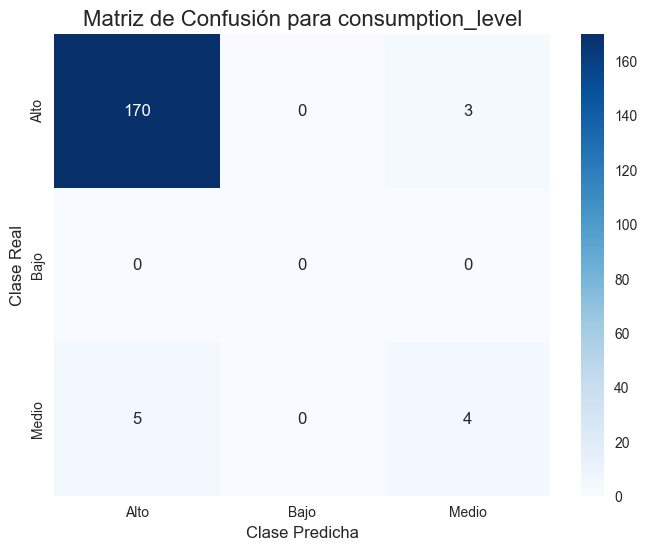

In [44]:
# Se realizan predicciones en el conjunto de prueba.
y_pred_class = dtc.predict(X_test_class)
y_pred_proba_class = dtc.predict_proba(X_test_class) # Probabilidades (opcional)

# Calcular métricas de evaluación
accuracy_class = accuracy_score(y_test_class, y_pred_class)

print(f"\n--- Resultados de Evaluación para DecisionTreeClassifier ({target_class}) ---")
print(f"Accuracy: {accuracy_class:.4f}")

print("\nInforme de Clasificación:")
report = classification_report(y_test_class, y_pred_class, zero_division=0)
print(report)

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_class, y_pred_class, labels=dtc.classes_) # Usar dtc.classes_ para el orden

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dtc.classes_, yticklabels=dtc.classes_)
plt.title(f'Matriz de Confusión para {target_class}', fontsize=16)
plt.xlabel('Clase Predicha', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.show()

Se observa en las métricas calculadas, que el modelo bajo estos hiperparámetros no evalua correctamente los datos, esto debido a que al tratarse de una serie de tiempo la división de datos no es equitativa, por lo que se debe realizar una división de datos más adecuada para el problema, debido a esto el modelo puede aprender mucho de tiempos en los cuales no se tienen tanta información de todos los niveles o solo se tiene mayor información de un  nivel en particular, para este caso se observa mayor afinidad con el nivel alto, ya que el los datos de testeo en este caso corresponden a los ultimos años en los cuales la energía eólica comenzó a tener un mayor impacto en la matriz energética de la región.

### 3.6. Optimización de Hiperparámetros

Se utiliza GridSearchCV con TimeSeriesSplit para optimizar los hiperparámetros del DecisionTreeClassifier, como max_depth y min_samples_split. La métrica f1_weighted evalúa el rendimiento en clases desbalanceadas.

In [45]:
# Se proponen los hiperparámetros para la búsqueda de cuadrícula (Grid Search) para el modelo de clasificación.
param_grid_dtc = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Usar TimeSeriesSplit si la secuencia importa para la clasificación
tscv_class = TimeSeriesSplit(n_splits=5)

grid_search_dtc = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dtc,
    cv=tscv_class, # o un entero para KFold si el split no es cronológico
    scoring='f1_weighted', # Usar f1_weighted o f1_macro si hay desbalance
    verbose=1,
    n_jobs=-1
)

grid_search_dtc.fit(X_train_class, y_train_class)

print(f"\nMejores Hiperparámetros para DecisionTreeClassifier: {grid_search_dtc.best_params_}")
print(f"Mejor puntuación (F1-weighted) en CV: {grid_search_dtc.best_score_:.4f}")

best_dtc = grid_search_dtc.best_estimator_

# Re-evaluar el mejor modelo en el conjunto de prueba
y_pred_best_dtc = best_dtc.predict(X_test_class)
print("\nInforme de Clasificación del Mejor Modelo DTC en Test Set:")
print(classification_report(y_test_class, y_pred_best_dtc, zero_division=0))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits

Mejores Hiperparámetros para DecisionTreeClassifier: {'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Mejor puntuación (F1-weighted) en CV: 0.7256

Informe de Clasificación del Mejor Modelo DTC en Test Set:
              precision    recall  f1-score   support

        Alto       0.97      0.98      0.98       173
       Medio       0.57      0.44      0.50         9

    accuracy                           0.96       182
   macro avg       0.77      0.71      0.74       182
weighted avg       0.95      0.96      0.95       182



### 3.7. Conclusión y Guardado del Modelo

Luego de modelar la base de datos por medio del *Decision Tree Classifier* se observa que este modelo no se ajusta correctamente a la base de datos, ya que el modelo no logra aprender de los datos y requeriría una correción en estos para poder ajustarse correctamente.

In [46]:
model_filename_class = f'../models/dtc_{target_classification.lower().replace(" ", "_")}_level.joblib'
joblib.dump(dtc, model_filename_class) # O best_dtc
print(f"\nModelo de clasificación guardado en: {model_filename_class}")


Modelo de clasificación guardado en: ../models/dtc_wind_energy_level.joblib
